# Analysis for Business Entrepreneurs in Berlin - The Battle of the Neighborhoods
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology and Data Processing](#methodology)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

this project aims to better infrom the interested stakeholders who want to check different variables of success with respect to each neighborhood(locality) before starting a business in Berlin, whether it's a small business or housing/real estate business.

## Data Description<a name="data"></a>

I decided to use neighborhood density, business density, and tourism as the deciding variables in this project.


The data was acquired from different sources with different methods and in some cases extrapolated from the already existing data.


The neighborhoods, boroughs and neighborhood density data was scraped from the wiki page: https://en.wikipedia.org/wiki/Boroughs_and_neighborhoods_of_Berlin


Tourism data was acquired from: https://www.statistik-berlin-brandenburg.de/webapi/jsf/tableView/tableView.xhtml


Venues data was acquired from the Foursquare API


Geojson of neighborhoods (Ortsteile) of Berlin city from:

https://common-data.carto.com/tables/berlin_ortsteile/public/map



## Methodology and Data Processing <a name="methodology"></a>

lets start by importing the necessary libraries:

In [2]:
pip install bs4

     |████████████████████████████████| 122kB 8.1MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install lxml

     |████████████████████████████████| 5.5MB 6.5MB/s eta 0:00:01  |████████████████████████████████| 5.5MB 6.5MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests 
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import folium
#from geopy.geocoders import Nominatim 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import json
import math
from sklearn import linear_model
%matplotlib inline

get the Boroughs and neighborhoods of Berlin wiki page into a soup object:

In [3]:
website_page = requests.get('https://en.wikipedia.org/wiki/Boroughs_and_neighborhoods_of_Berlin').text
soup = BeautifulSoup(website_page,'lxml')

the data of neighborhoods, boroughs and population density are in the tables:

In [4]:
tables = soup.findAll('table')

### Get the boroughs

get boroughs by the order of neighborhood tables:

In [5]:
Boroughs_list = []
links = soup.findAll('dt')
for link in links:
    link_soup = BeautifulSoup(str(link),'lxml')
    title = link_soup.find('a')
    Boroughs_list.append(title.string)
Boroughs_list

['Mitte',
 'Friedrichshain-Kreuzberg',
 'Pankow',
 'Charlottenburg-Wilmersdorf',
 'Spandau',
 'Steglitz-Zehlendorf',
 'Tempelhof-Schöneberg',
 'Neukölln',
 'Treptow-Köpenick',
 'Marzahn-Hellersdorf',
 'Lichtenberg',
 'Reinickendorf']

### Get tourism data

get the 'by borough' tourism data of Berlin from the text file:

In [6]:
text = []
with open("tourism.txt", 'rb') as f:
    line = f.readline().decode("iso-8859-1")
    while line:
        text.append(line)
        line = f.readline().decode("iso-8859-1")

text = [line[3::] for line in text]
text[-1] = text[-1] + '\r\n'
text = [line[:-2] for line in text]
borough = [i.split('\t')[0] for i in text]
guests = [int((i.split('\t')[1]).replace(',',"")) for i in text]
overnightstay = [int((i.split('\t')[2]).replace(',',""))  for i in text]

#make a tourism metric
overnightstay_metric = np.array(overnightstay)/min(overnightstay)
guests_metric  = np.array(guests)/min(guests)
tourism_metric = (guests_metric + overnightstay_metric)/2

# make it as dict to use later to extract the metric for each borough
borough_tourism_metric = dict(zip(borough,tourism_metric))


df_tourism = pd.DataFrame()
df_tourism['Borough'] = borough
df_tourism['Number of guests'] = guests 
df_tourism['Overnightstay'] = overnightstay
df_tourism['Tourism metric'] = tourism_metric
df_tourism

,Borough,Number of guests,Overnightstay,Tourism metric
0,Mitte,5732248,13923473,63.106762
1,Friedrichshain-Kreuzberg,1668654,4185545,18.642645
2,Pankow,523334,1467454,6.165038
3,Charlottenburg-Wilmersdorf,2747572,6570319,30.035502
4,Spandau,259017,582374,2.755367
5,Steglitz-Zehlendorf,210769,508449,2.313169
6,Tempelhof-Schöneberg,823926,2040358,9.150990
7,Neukölln,403625,899056,4.276291
8,Treptow-Köpenick,327712,703177,3.416936
9,Marzahn-Hellersdorf,83131,243166,1.000000


### Get neighborhood density data

extract neighborhood, neighborhood density, from wiki tables and adjust the borough and tourism_metric lists to the same size:

In [7]:
# get neighborhoods, population density
localities_list = []
tourism_metric_adjusted = []
Boroughs_list_adjusted = []
for i in range(2,14):
    count = 0 
    for tag in tables[i].find_all("td"):
        localities_list.append(tag.text[:-1])
        count += 1
    for r in range(int(count/4)):
        Boroughs_list_adjusted.append(Boroughs_list[i-2])
        tourism_metric_adjusted.append(borough_tourism_metric[Boroughs_list[i-2]])

In [8]:
#split and process neighborhoods and population density
localities_list = [ x for x in ([s.replace('\xa0','') for s in ([s.replace('.','') for s in ([s.replace(',','') for s in localities_list])]) ]) ]
localities_list = list(filter(None, localities_list))
localities_names = localities_list[0::4]
localities_density = localities_list[3::4]
localities_names =[ s[7::] for s in  ([s.strip() for s in localities_names]) ]
localities_density = [int(x) for x in localities_density]

In [9]:
df_neighborhoods = pd.DataFrame()
df_neighborhoods['Neighborhood'] = localities_names
df_neighborhoods['Borough'] = Boroughs_list_adjusted
df_neighborhoods['Neighborhood density'] =  localities_density
df_neighborhoods['Tourism metric'] =  tourism_metric_adjusted
df_neighborhoods.head(10)

,Neighborhood,Borough,Neighborhood density,Tourism metric
0,Mitte,Mitte,7445,63.106762
1,Moabit,Mitte,8993,63.106762
2,Hansaviertel,Mitte,11111,63.106762
3,Tiergarten,Mitte,2415,63.106762
4,Wedding,Mitte,8273,63.106762
5,Gesundbrunnen,Mitte,13496,63.106762
6,Friedrichshain,Friedrichshain-Kreuzberg,11662,18.642645
7,Kreuzberg,Friedrichshain-Kreuzberg,14184,18.642645
8,Prenzlauer Berg,Pankow,12991,6.165038
9,Weißensee,Pankow,5736,6.165038


### Calculate coordinates

since some of the coordinates that were acquired by geocoder or from wiki-geohack were off we try to calculate the center of each neighborhood,
to do that we extract the 'polygon' of each neighborhood from the geojson file and process it:

In [10]:
!pip install shapely
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
print('shapely installed and imported!')

     |████████████████████████████████| 1.0MB 11.0MB/s eta 0:00:01
shapely installed and imported!


In [11]:
# get neighborhoods' polygons
polygons = []
names = []
polygons_dict = {}
with open('berlin_ortsteile.geojson') as f:
    data = json.load(f)
count = 0
for feature in data['features']:
    #print (str(count)+' getting polygon of '+feature['properties']['name'])
    polygons_dict.update({feature['properties']['name']:feature['geometry']['coordinates']})
    count = count + 1
print('polygons acquired!')

polygons acquired!


In [12]:
# get center of polygon
def get_centroid(polygon):
    polygon = np.array(polygon)
    polygon = polygon[0][:][0][:]
    polygon = polygon.T
    x = polygon[:][0].tolist()
    y = polygon[:][1].tolist()
    centroid = (((max(x)-min(x)) / 2)+min(x), ((max(y)-min(y)) / 2)+min(y))
    return centroid

we calculate the center coordinates for each neighborhood and merge it with the neighborhoods dataframe:

In [13]:
names = []
localities_coordinates = []
for neighborhood in polygons_dict.keys():
    names.append(neighborhood)
    localities_coordinates.append(get_centroid(polygons_dict[neighborhood]))
localities_coordinates = np.array(localities_coordinates).T
df_coordinates = pd.DataFrame()
df_coordinates['Neighborhood'] = names
df_coordinates['Latitude'] = localities_coordinates[1]
df_coordinates['Longitude'] = localities_coordinates[0]
df_berlin = pd.merge(df_neighborhoods, df_coordinates, on='Neighborhood')
df_berlin.head(10)

,Neighborhood,Borough,Neighborhood density,Tourism metric,Latitude,Longitude
0,Mitte,Mitte,7445,63.106762,52.522220,13.397631
1,Moabit,Mitte,8993,63.106762,52.529050,13.342629
2,Hansaviertel,Mitte,11111,63.106762,52.518229,13.342319
3,Tiergarten,Mitte,2415,63.106762,52.510762,13.353846
4,Wedding,Mitte,8273,63.106762,52.550058,13.338227
5,Gesundbrunnen,Mitte,13496,63.106762,52.550437,13.384709
6,Friedrichshain,Friedrichshain-Kreuzberg,11662,18.642645,52.508536,13.455603
7,Kreuzberg,Friedrichshain-Kreuzberg,14184,18.642645,52.496556,13.410784
8,Prenzlauer Berg,Pankow,12991,6.165038,52.539254,13.434476
9,Weißensee,Pankow,5736,6.165038,52.552953,13.462319


### Half the data

we are interested in the more populous half of Berlin neighborhoods, so lets filter the data:

In [14]:
df_berlin.describe()

,Neighborhood density,Tourism metric,Latitude,Longitude
count,96.000000,96.000000,96.000000,96.000000
mean,4697.302083,10.017518,52.512402,13.402081
std,4120.801471,15.564494,0.066364,0.132896
min,144.000000,1.000000,52.369611,13.137632
25%,1687.750000,2.755367,52.457439,13.308584
50%,3301.500000,4.276291,52.510233,13.398779
75%,5830.250000,6.165038,52.570168,13.494899
max,16204.000000,63.106762,52.647514,13.708946


In [15]:
df_berlin_filtered = df_berlin[(df_berlin['Neighborhood density'] > 3300) ].reset_index(drop=True)
df_berlin_filtered.shape

(48, 6)

In [16]:
# also filter neighborhoods we are interested in, in the polygons_dict
polygons_dict_filtered = {}
for Neighborhood in df_berlin_filtered['Neighborhood'].tolist():
    polygons_dict_filtered.update({Neighborhood:polygons_dict[Neighborhood]})

### Get venues

get venues for each neighborhood from foursquare api:

In [17]:
fname = 'credentials.txt'
with open(fname) as f:
    content = f.readlines()
content = [x.strip() for x in content] 

CLIENT_ID = content[0]
CLIENT_SECRET = content[1] 
VERSION = '20180605' 

In [18]:
def getNearbyVenues(neighborhoods, latitudes, longitudes, radius=1000,LIMIT=100):
    
    venues_list=[]
    for neighborhood, lat, lng in zip(neighborhoods, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            neighborhood, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
berlin_venues = getNearbyVenues(
                                   neighborhoods=df_berlin_filtered['Neighborhood'],
                                   latitudes=df_berlin_filtered['Latitude'],
                                   longitudes=df_berlin_filtered['Longitude']
                                  )
print('Done acquiring venues!')

Done acquiring venues!


### Process venues

since the acquired venues are at a max radius from a certain coordinate, it could be that 2 circles from different neighborhoods are overlapping,
this will result in getting the same venue twice or even more, so we check for duplicates according to the coordinates: 

In [20]:
Venue_Latitude = berlin_venues['Venue Latitude'].tolist()
Venue_Longitude = berlin_venues['Venue Longitude'].tolist()
Venues_coordinates = list(zip(Venue_Latitude, Venue_Longitude))
Venues_coordinates_set = set(Venues_coordinates)
print ('number of duplicates: '+ str(len(Venues_coordinates) - len(Venues_coordinates_set)))

number of duplicates: 67


that is fixed by adding both coordinates into a single indexed column and then dropping the duplicates:

In [21]:
berlin_venues['Venues_coordinates'] = Venues_coordinates
berlin_venues_unique = berlin_venues.drop_duplicates(subset = "Venues_coordinates")
Venue_Latitude = berlin_venues_unique['Venue Latitude'].tolist()
Venue_Longitude = berlin_venues_unique['Venue Longitude'].tolist()
Venues_coordinates = list(zip(Venue_Latitude, Venue_Longitude))
Venues_coordinates_set = set(Venues_coordinates)
print ('number of duplicates: '+ str(len(Venues_coordinates) - len(Venues_coordinates_set)))
print('old number of venues '+str(berlin_venues.shape[0]))
print('unique number of venues '+str(berlin_venues_unique.shape[0]))
berlin_venues_unique.head()

number of duplicates: 0
old number of venues 2358
unique number of venues 2291


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venues_coordinates
0,Mitte,52.52222,13.397631,Ischtar-Tor,52.520742,13.397205,Historic Site,"(52.520741776446705, 13.397204678584995)"
1,Mitte,52.52222,13.397631,Buchhandlung Walther König,52.521301,13.400758,Bookstore,"(52.52130069676686, 13.40075831891714)"
2,Mitte,52.52222,13.397631,Monbijoupark,52.523134,13.396894,Park,"(52.52313441612033, 13.396893739700317)"
3,Mitte,52.52222,13.397631,James-Simon-Park,52.521907,13.399361,Park,"(52.52190716050168, 13.399361371994019)"
4,Mitte,52.52222,13.397631,Märchenhütte Jacob,52.523010,13.395117,Indie Theater,"(52.52301014591696, 13.395116694524507)"


one more thing to pay attention to is since the venues are acquired by radius, it could be that the circle is covering a part of another neighborhood

In [22]:
# check if venue in right neighborhood
def check_if_point_in_polygon(polygon,point):
    polygon = np.array(polygon)
    polygon = polygon[0][:][0][:]
    polygon = polygon.T
    x = polygon[:][0].tolist()
    y = polygon[:][1].tolist()
    polygon = Polygon(list(zip(y,x)))
    point = Point(point)
    if polygon.contains(point):
        return('Correct Neighborhood')
    else:
        return('Wrong Neighborhood')

In [23]:
# check in which neighborhood is the venue
def check_where(polygons_dict,point):
    for neighborhood in polygons_dict.keys():
        if check_if_point_in_polygon(polygons_dict[neighborhood],point) == 'Correct Neighborhood':
            return(neighborhood)
    return('outsider')

so first right-wrong list is created to indicate if the venue is in the right neighborhood and add it to the dataframe:

In [24]:
true_false_list = []
for Neighborhood,Venue_coordinates in zip(berlin_venues_unique['Neighborhood'],berlin_venues_unique['Venues_coordinates']):
    true_false_list.append(check_if_point_in_polygon(polygons_dict_filtered[Neighborhood],Venue_coordinates))
try:
    berlin_venues_unique.drop(columns='correct_or_wrong', axis=1, inplace=True)
except:
    pass

berlin_venues_unique.insert(loc=0, column='correct_or_wrong', value=true_false_list) 

lets take a look at the wrongly classified venues:

In [25]:
berlin_venues_false =  berlin_venues_unique[berlin_venues_unique['correct_or_wrong'] == 'Wrong Neighborhood']
print(berlin_venues_false.shape)
berlin_venues_false.head()

(218, 9)


,correct_or_wrong,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venues_coordinates
158,Wrong Neighborhood,Moabit,52.529050,13.342629,Lir Irish Pub,52.520284,13.344341,Irish Pub,"(52.520284479191844, 13.344340720449152)"
168,Wrong Neighborhood,Moabit,52.529050,13.342629,Konditorei & Café Buchwald,52.521197,13.347825,Pastry Shop,"(52.521197, 13.347825)"
206,Wrong Neighborhood,Hansaviertel,52.518229,13.342319,Englischer Garten,52.516704,13.347423,Park,"(52.516703999250495, 13.347423076629639)"
208,Wrong Neighborhood,Hansaviertel,52.518229,13.342319,Siegessäule,52.514487,13.350116,Monument / Landmark,"(52.51448740902706, 13.35011601448059)"
211,Wrong Neighborhood,Hansaviertel,52.518229,13.342319,Schlosspark Bellevue,52.517971,13.351049,Park,"(52.517970572031565, 13.351049423217773)"


234 wrongly classified venues, lets take the first one and check where is it:

In [26]:
point = [52.520284479191844, 13.344340720449152]
check_where(polygons_dict_filtered,point)

'Hansaviertel'

to make sure and visualize, lets plot the wrong and right neighborhoods with the point (venue location):

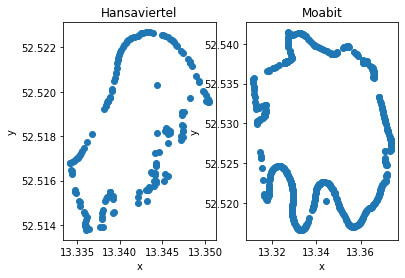

Hansaviertel: Correct Neighborhood
Moabit: Wrong Neighborhood


In [27]:
point = [52.520284479191844, 13.344340720449152]
neighborhood0 = 'Hansaviertel'
polygon0 = np.array(polygons_dict[neighborhood0])
polygon0 = polygon0.T

neighborhood1 = 'Moabit'
polygon1 = np.array(polygons_dict[neighborhood1])
polygon1 = polygon1.T

fig, ax = plt.subplots(nrows=1, ncols=2)

#plt.figure(figsize=(10,5))
plt.rcParams["figure.figsize"] = (15,5)

x0 = [float(i) for i in polygon0[:][0]]
y0 = [float(i) for i in polygon0[:][1]]
x0.append(float(point[1]))
y0.append(float(point[0]))

x1 = [float(i) for i in polygon1[:][0]]
y1 = [float(i) for i in polygon1[:][1]]
x1.append(float(point[1]))
y1.append(float(point[0]))

ax[0].scatter(x0, y0)
ax[0].set_title('{}'.format(neighborhood0))
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

ax[1].scatter(x1, y1)
ax[1].set_title('{}'.format(neighborhood1))
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')

plt.show()

print(neighborhood0 +': '+ check_if_point_in_polygon(polygons_dict[neighborhood0],point))
print(neighborhood1 +': '+ check_if_point_in_polygon(polygons_dict[neighborhood1],point))

lets fix it for all of them:

In [28]:
corrected_list = []
count = 0
for neighborhood,venue_coordinates in zip(berlin_venues_false['Neighborhood'].tolist(),berlin_venues_false['Venues_coordinates'].tolist()):
    corrected_list.append(check_where(polygons_dict_filtered,venue_coordinates))

In [29]:
berlin_venues_corrected = berlin_venues_false

try:
    berlin_venues_corrected.drop(columns='Neighborhood', axis=1, inplace=True)
    berlin_venues_corrected.drop(columns='correct_or_wrong', axis=1, inplace=True)
except:
    pass

berlin_venues_corrected.insert(loc=0, column='Neighborhood', value=corrected_list)

berlin_venues_corrected.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venues_coordinates
158,Hansaviertel,52.529050,13.342629,Lir Irish Pub,52.520284,13.344341,Irish Pub,"(52.520284479191844, 13.344340720449152)"
168,Hansaviertel,52.529050,13.342629,Konditorei & Café Buchwald,52.521197,13.347825,Pastry Shop,"(52.521197, 13.347825)"
206,outsider,52.518229,13.342319,Englischer Garten,52.516704,13.347423,Park,"(52.516703999250495, 13.347423076629639)"
208,outsider,52.518229,13.342319,Siegessäule,52.514487,13.350116,Monument / Landmark,"(52.51448740902706, 13.35011601448059)"
211,outsider,52.518229,13.342319,Schlosspark Bellevue,52.517971,13.351049,Park,"(52.517970572031565, 13.351049423217773)"


notice that there are 'outsider' neighborhoods, these are venues that lie in the neighborhoods we filtered out:

In [30]:
print('venues_corrected with outsiders: ' + str(berlin_venues_corrected.shape[0]))
berlin_venues_corrected_without_outsiders = berlin_venues_corrected[berlin_venues_corrected['Neighborhood'] != 'outsider']
print('venues_corrected without outsiders: ' + str(berlin_venues_corrected_without_outsiders.shape[0]))
print('number of outsiders: ' + str(berlin_venues_corrected.shape[0] - berlin_venues_corrected_without_outsiders.shape[0]))

venues_corrected with outsiders: 218
venues_corrected without outsiders: 152
number of outsiders: 66


and now to update the original datafram with the corrected one and then drop the 'outsiders'

In [31]:
df_venues_final= berlin_venues_unique
df_venues_final.update(berlin_venues_corrected)
df_venues_final = df_venues_final[df_venues_final['Neighborhood'] != 'outsider']
try:
    df_venues_final.drop(columns='correct_or_wrong', axis=1, inplace=True)
except:
    pass
print(df_venues_final.shape)
df_venues_final.head()

(2225, 8)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:5732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venues_coordinates
0,Mitte,52.52222,13.397631,Ischtar-Tor,52.520742,13.397205,Historic Site,"(52.520741776446705, 13.397204678584995)"
1,Mitte,52.52222,13.397631,Buchhandlung Walther König,52.521301,13.400758,Bookstore,"(52.52130069676686, 13.40075831891714)"
2,Mitte,52.52222,13.397631,Monbijoupark,52.523134,13.396894,Park,"(52.52313441612033, 13.396893739700317)"
3,Mitte,52.52222,13.397631,James-Simon-Park,52.521907,13.399361,Park,"(52.52190716050168, 13.399361371994019)"
4,Mitte,52.52222,13.397631,Märchenhütte Jacob,52.523010,13.395117,Indie Theater,"(52.52301014591696, 13.395116694524507)"


check again for duplicates and wrongly placed venues

In [32]:
Venue_Latitude = df_venues_final['Venue Latitude'].tolist()
Venue_Longitude = df_venues_final['Venue Longitude'].tolist()
Venues_coordinates = list(zip(Venue_Latitude, Venue_Longitude))
Venues_coordinates_set = set(Venues_coordinates)
print('duplicates: '+str(len(Venues_coordinates) - len(Venues_coordinates_set)))


count = 0
for Neighborhood,Venue_coordinates in zip(df_venues_final['Neighborhood'],df_venues_final['Venues_coordinates']):
    if check_if_point_in_polygon(polygons_dict_filtered[Neighborhood],Venue_coordinates) != 'Correct Neighborhood':
        count += 1
print('wrongly placed venues: '+ str(count))

duplicates: 0
wrongly placed venues: 0


get the venues count for each neighborhood:

In [33]:
df_venues_count= df_venues_final.groupby('Neighborhood').count().reset_index()
df_venues_count  = df_venues_count.sort_values(by=['Venue'], ascending=False)
df_venues_count = df_venues_count[['Neighborhood','Venue']].rename(index=str, columns={"Venue": "Venues count"})
df_venues_count.head()

,Neighborhood,Venues count
5,Charlottenburg,132
24,Moabit,109
27,Neukölln,108
10,Friedrichshain,108
46,Wilmersdorf,107


and make a business density metric:

In [34]:
venues_count_list = df_venues_count['Venues count'].tolist()
min_count = min(venues_count_list)
Business_density_ratio = (np.array(venues_count_list)/min_count).tolist()
df_venues_count.insert(loc=2, column='Business density metric', value=Business_density_ratio )
df_venues_count.head()

,Neighborhood,Venues count,Business density metric
5,Charlottenburg,132,26.4
24,Moabit,109,21.8
27,Neukölln,108,21.6
10,Friedrichshain,108,21.6
46,Wilmersdorf,107,21.4


merge it with the first dataframe:

In [35]:
df_berlin_final = pd.merge(df_berlin_filtered, df_venues_count, on='Neighborhood')
df_berlin_final.head(10)

,Neighborhood,Borough,Neighborhood density,Tourism metric,Latitude,Longitude,Venues count,Business density metric
0,Mitte,Mitte,7445,63.106762,52.522220,13.397631,100,20.0
1,Moabit,Mitte,8993,63.106762,52.529050,13.342629,109,21.8
2,Hansaviertel,Mitte,11111,63.106762,52.518229,13.342319,12,2.4
3,Wedding,Mitte,8273,63.106762,52.550058,13.338227,53,10.6
4,Gesundbrunnen,Mitte,13496,63.106762,52.550437,13.384709,87,17.4
5,Friedrichshain,Friedrichshain-Kreuzberg,11662,18.642645,52.508536,13.455603,108,21.6
6,Kreuzberg,Friedrichshain-Kreuzberg,14184,18.642645,52.496556,13.410784,97,19.4
7,Prenzlauer Berg,Pankow,12991,6.165038,52.539254,13.434476,105,21.0
8,Weißensee,Pankow,5736,6.165038,52.552953,13.462319,48,9.6
9,Pankow,Pankow,9868,6.165038,52.567234,13.411147,74,14.8


### Process and Cluster the Data

process the venues to onehot and get the frequency of each venue category in each neighborhood

In [36]:
# one hot encoding
berlin_onehot = pd.get_dummies(df_venues_final[['Venue Category']], prefix="", prefix_sep="")
berlin_onehot.head()
try:   
    berlin_onehot.drop(['Neighborhood'], axis=1,inplace = True)
except:
    pass
berlin_onehot.insert(loc=0, column='Neighborhood', value=df_venues_final['Neighborhood'])
berlin_grouped = berlin_onehot.groupby('Neighborhood').mean().reset_index()
print('berlin_grouped.shape')
berlin_grouped.head()

berlin_grouped.shape


,Neighborhood,ATM,Accessories Store,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Waterfront,Whisky Bar,Windmill,Wine Bar,Wine Shop,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Alt-Hohenschönhausen,0.0,0.0,0.0,0.0,0.0,0.0,0.021277,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alt-Treptow,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Altglienicke,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Baumschulenweg,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Buckow,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


now get the top 10 most common venues:

In [37]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [38]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = berlin_grouped['Neighborhood']

for ind in np.arange(berlin_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(berlin_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alt-Hohenschönhausen,Tram Station,Supermarket,Drugstore,Café,Discount Store,Bakery,Lake,Hardware Store,Gym / Fitness Center,Gym
1,Alt-Treptow,Café,Italian Restaurant,Park,Supermarket,Vegetarian / Vegan Restaurant,Seafood Restaurant,Bakery,Bus Stop,Indian Restaurant,Bistro
2,Altglienicke,Supermarket,Restaurant,Tapas Restaurant,Furniture / Home Store,Food Stand,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint
3,Baumschulenweg,Supermarket,Vietnamese Restaurant,Drugstore,Café,Ice Cream Shop,Garden Center,Asian Restaurant,Football Stadium,Forest,Fountain
4,Buckow,Hotel,Supermarket,Video Store,German Restaurant,Greek Restaurant,Gym / Fitness Center,Chinese Restaurant,Fast Food Restaurant,Mexican Restaurant,Bus Stop


cluster the above data with kMeans, but first lets check the error with different values of clusters(k): 

In [39]:
berlin_grouped_clustering = berlin_grouped.drop('Neighborhood', 1)

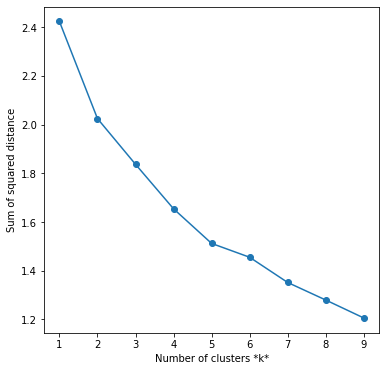

In [40]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(berlin_grouped_clustering)
    sse.append(km.inertia_)

plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

the Sum of Squared distance/Error (SSE) always drops with increasing values of clusters(k),
however rate of drop/decrease is not sharp after k=3, so we choose k=3 for our model.

In [41]:
kclusters = 3
kmeans = KMeans(n_clusters=kclusters,init='k-means++', random_state=0).fit(berlin_grouped_clustering)

In [42]:
# add clustering labels and merge dataframes
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
berlin_merged = df_berlin_final.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
berlin_merged.head()

,Neighborhood,Borough,Neighborhood density,Tourism metric,Latitude,Longitude,Venues count,Business density metric,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Mitte,Mitte,7445,63.106762,52.522220,13.397631,100,20.0,1,Coffee Shop,Café,Hotel,History Museum,Art Gallery,Bookstore,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Art Museum
1,Moabit,Mitte,8993,63.106762,52.529050,13.342629,109,21.8,1,Café,Italian Restaurant,Bar,Restaurant,Hotel,Drugstore,Burger Joint,German Restaurant,Vietnamese Restaurant,Pizza Place
2,Hansaviertel,Mitte,11111,63.106762,52.518229,13.342319,12,2.4,1,Art Museum,Gastropub,Pub,Theater,Mediterranean Restaurant,Hotel,Pastry Shop,Sporting Goods Shop,Currywurst Joint,Irish Pub
3,Wedding,Mitte,8273,63.106762,52.550058,13.338227,53,10.6,1,Café,Big Box Store,Metro Station,Middle Eastern Restaurant,Doner Restaurant,Bar,Park,Tram Station,Bakery,Chinese Restaurant
4,Gesundbrunnen,Mitte,13496,63.106762,52.550437,13.384709,87,17.4,1,Café,Bar,Bakery,Turkish Restaurant,Supermarket,Drugstore,Nightclub,Bookstore,Dive Bar,Performing Arts Venue


## Results <a name="results"></a>

### Visualize the results

now we can create a choropleth map of the population density in each neighborhood:

In [43]:
berlin_neighborhoods_geo = r'berlin_ortsteile.geojson'
berlin_map = folium.Map(location=[52.5200, 13.4050], zoom_start=11, tiles='Mapbox Bright')



threshold_scale = np.linspace(df_berlin['Neighborhood density'].min(),
                              df_berlin['Neighborhood density'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() 
threshold_scale[-1] = threshold_scale[-1] + 1 



berlin_map.choropleth(
    geo_data=berlin_neighborhoods_geo,
    data=df_berlin,
    columns=['Neighborhood', 'Neighborhood density'],
    key_on='feature.properties.name',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population density per km^2 in Berlin'
)

we add markers to the neighborhoods on the map:
<br/>the inner circle area represents the Business density metric in neighborhood (click on inner) - scaled by 2 for better visualization
<br/>the outer circle area represents the Tourism metric in the corresponding borough added to the Business density metric (click on outer) - scaled by 2 for better visualization
<br/>the color represents the cluster

In [44]:
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

z=zip(berlin_merged['Venues count'], berlin_merged['1st Most Common Venue'], berlin_merged['Business density metric'], berlin_merged['Latitude'], berlin_merged['Longitude'], berlin_merged['Neighborhood'], berlin_merged['Cluster Labels'],berlin_merged['Tourism metric'])


# add markers to the map
markers_colors = []
for Venues_count, Common_Venue, Business_density_metric, lat, lng, neighborhood,cluster,tourism_metric in z:
    label = '{} (Business density metric: {}) [Cluster: {}]'.format(neighborhood,Business_density_metric,cluster)
    label2 = '{} (1st Most Common Venue: {}) (Tourism metric: {})'.format(neighborhood,Common_Venue,int(tourism_metric))
    folium.CircleMarker(
        [lat, lng],
        radius=math.sqrt(5*Business_density_metric/math.pi),
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.5).add_to(berlin_map)
    
    folium.CircleMarker(
        radius=math.sqrt((5*tourism_metric+5*Business_density_metric)/math.pi),
        popup=label2,
        location=[lat, lng],
        color=rainbow[int(cluster)-1],
        fill=False).add_to(berlin_map)
       
berlin_map

the area difference between the inner circle and the outer circle shows the ratio between the business density - tourism,
of each neighborhood with respect to the whole dataset (see conclusion)

it seems that the business density is not meeting tourism metric and population density in cluster 1, its a possible situation of high demand - low supply, so lets check it out:

In [45]:
cluster_0 = berlin_merged.loc[berlin_merged['Cluster Labels'] == 0, berlin_merged.columns[[0] + list(range(5, berlin_merged.shape[1]))]]
cluster_1 = berlin_merged.loc[berlin_merged['Cluster Labels'] == 1, berlin_merged.columns[[0] + list(range(5, berlin_merged.shape[1]))]]
cluster_2 = berlin_merged.loc[berlin_merged['Cluster Labels'] == 2, berlin_merged.columns[[0] + list(range(5, berlin_merged.shape[1]))]]
cluster_0_all = berlin_merged.loc[berlin_merged['Cluster Labels'] == 0]
cluster_1_all = berlin_merged.loc[berlin_merged['Cluster Labels'] == 1]
cluster_2_all = berlin_merged.loc[berlin_merged['Cluster Labels'] == 2]

In [46]:
cluster_1.head()

,Neighborhood,Longitude,Venues count,Business density metric,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Mitte,13.397631,100,20.0,1,Coffee Shop,Café,Hotel,History Museum,Art Gallery,Bookstore,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Art Museum
1,Moabit,13.342629,109,21.8,1,Café,Italian Restaurant,Bar,Restaurant,Hotel,Drugstore,Burger Joint,German Restaurant,Vietnamese Restaurant,Pizza Place
2,Hansaviertel,13.342319,12,2.4,1,Art Museum,Gastropub,Pub,Theater,Mediterranean Restaurant,Hotel,Pastry Shop,Sporting Goods Shop,Currywurst Joint,Irish Pub
3,Wedding,13.338227,53,10.6,1,Café,Big Box Store,Metro Station,Middle Eastern Restaurant,Doner Restaurant,Bar,Park,Tram Station,Bakery,Chinese Restaurant
4,Gesundbrunnen,13.384709,87,17.4,1,Café,Bar,Bakery,Turkish Restaurant,Supermarket,Drugstore,Nightclub,Bookstore,Dive Bar,Performing Arts Venue


it seems there are a lot of cafes in this cluster, let make clearer with wordcloud what kind of busnisses the common in this cluster:

In [47]:
# install wordcloud
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
print ('Wordcloud is installed and imported!')

     |████████████████████████████████| 368kB 7.5MB/s eta 0:00:01
Wordcloud is installed and imported!


In [48]:
stopwords = set(STOPWORDS)
cloud = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

In [49]:
def get_cluster_word_cloud(cluster_df,cols):
    cluster_txt = []
    for i in range(4,cols+4):
        cluster_txt = cluster_txt + cluster_df.iloc[:, i].tolist()
    txt = ' '
    for s in cluster_txt:
        txt = txt + ' ' + str(s).replace(' ','')
    cloud.generate(txt)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

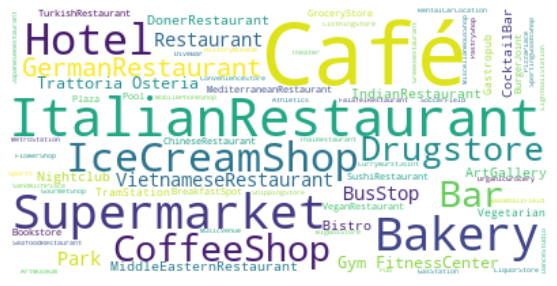

In [50]:
get_cluster_word_cloud(cluster_1,10) #use all 10 most common columns

so coffee shops, restaurants, supermarkets, bakeries, bars, hotels, ice cream shops.. however we chose all the data which means we gave more weight to the less common venues, which are arguably with less demand/competition
<br/>we can choose only 3 columns to see venues with more demand/competition

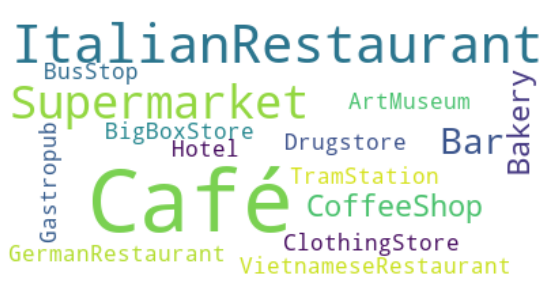

In [51]:
get_cluster_word_cloud(cluster_1,3) 

lets check cluster 0 too

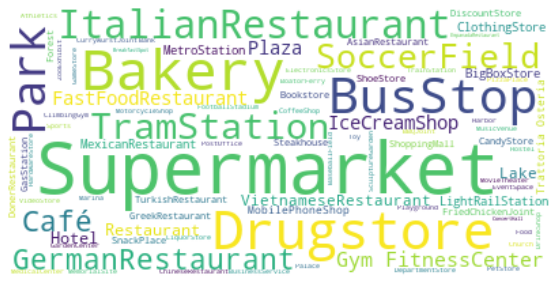

In [52]:
get_cluster_word_cloud(cluster_0,10)

so cafes, supermarkets and restaurants... looks right since its densely populated and touristic

now lets create some regression plots to more understand the connection between these variables in Berlin

In [53]:
df_berlin_final.head()

,Neighborhood,Borough,Neighborhood density,Tourism metric,Latitude,Longitude,Venues count,Business density metric
0,Mitte,Mitte,7445,63.106762,52.522220,13.397631,100,20.0
1,Moabit,Mitte,8993,63.106762,52.529050,13.342629,109,21.8
2,Hansaviertel,Mitte,11111,63.106762,52.518229,13.342319,12,2.4
3,Wedding,Mitte,8273,63.106762,52.550058,13.338227,53,10.6
4,Gesundbrunnen,Mitte,13496,63.106762,52.550437,13.384709,87,17.4


connection between neighborhood density and business density:

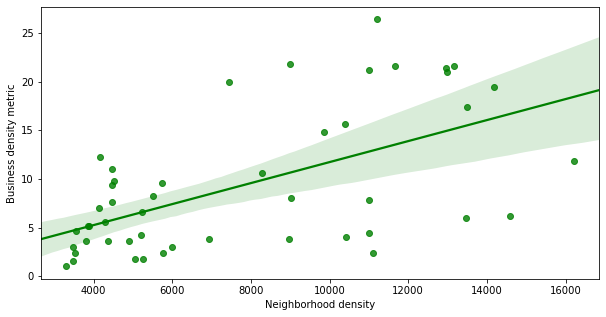

In [54]:
plt.rcParams["figure.figsize"] = (10,5)
ax = sns.regplot(x='Neighborhood density', y='Business density metric', data=df_berlin_final, color='green')

with increase of population the business density increases as expected, high demand - high supply

now lets check business density - tourism:

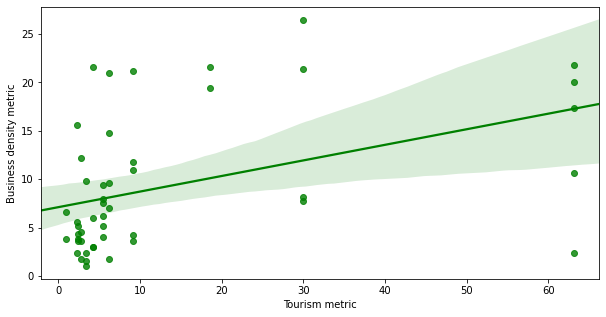

In [55]:
ax = sns.regplot(x='Tourism metric', y='Business density metric', data=df_berlin_final, color='green')

weaker relation between business density - tourism than between business density - neighborhood density, which can be a possibility of high demand - low supply

## Discussion <a name="discussion"></a>

As mentioned in the previous section there are so many ways to interpret the data, and that is better done with the stakeholders, as for the data itself it could be more comprehensive, the same research could be done with more data on tourism, businesses and even more variables could be integrated for better assessment.

Only half of the city was considered but if more data to be provided, one can consider the whole city and see if any patterns will emerge.

It is also worth mentioning that a temporal data could be so impactful if considered, however this all relates to the desire of the stakeholders and their interests.

## Conclusion <a name="conclusion"></a>

#### things that could be considered by business entrepreneurs:
<br/>1. where the 'color' is darker - neighborhood density high - high demand
<br/>2. where outer circle area bigger than the inner circle area - low business density with respect to tourism - less competition and possible high demand.
<br/>3. where outer circle area close to the inner circle area - high business density with respect to tourism - more competition and less demand.
<br/>4. options of the business category are words shown by the word cloud (depends on the cluster) - big words: more competition but possible high demand.
small words: less competition but possible low demand.
<br/> * for housing/real estate business its the opposite of 1 and 2 and the more diverse the wordcloud is the better.

##### Author: Azeer Esmail